<a href="https://colab.research.google.com/github/AT100/cmpt733-deepfake-detection/blob/main/mesonet_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tensorflow.keras.models import Model as KerasModel
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Reshape, Concatenate, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pylab as plt
from PIL import Image
import cv2
import pandas as pd
import os
from glob import glob
import numpy as np

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, save_model, load_model
from keras.utils import Sequence

In [ ]:
!git clone https://github.com/WittmannF/LRFinder.git
from LRFinder.keras_callback import LRFinder

Cloning into 'LRFinder'...
remote: Enumerating objects: 71, done.
remote: Total 71 (delta 0), reused 0 (delta 0), pack-reused 71
Unpacking objects: 100% (71/71), done.


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
IMGWIDTH = 256

In [4]:
# 3. Fit using Callback
#lr_finder = LRFinder(min_lr=0.0001, max_lr=0.1)

optimizer = Adam(lr = 0.01)

x = Input(shape = (IMGWIDTH, IMGWIDTH, 3))

x1 = Conv2D(8, (3, 3), padding='same', activation = 'relu')(x)
x1 = BatchNormalization()(x1)
x1 = MaxPooling2D(pool_size=(2, 2), padding='same')(x1)

x2 = Conv2D(8, (5, 5), padding='same', activation = 'relu')(x1)
x2 = BatchNormalization()(x2)
x2 = MaxPooling2D(pool_size=(2, 2), padding='same')(x2)

x3 = Conv2D(16, (5, 5), padding='same', activation = 'relu')(x2)
x3 = BatchNormalization()(x3)
x3 = MaxPooling2D(pool_size=(2, 2), padding='same')(x3)

x4 = Conv2D(16, (5, 5), padding='same', activation = 'relu')(x3)
x4 = BatchNormalization()(x4)
x4 = MaxPooling2D(pool_size=(4, 4), padding='same')(x4)

y = Flatten()(x4)
y = Dropout(0.5)(y)
y = Dense(16)(y)
y = LeakyReLU(alpha=0.1)(y)
y = Dropout(0.5)(y)
y = Dense(1, activation = 'sigmoid')(y)


model = keras.Model(inputs = x, outputs = y)
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])
#model.load_weights('/content/drive/MyDrive/Meso4_DF(1).h5')

In [ ]:
#rmdir train_images/.ipynb_checkpoints

rmdir: failed to remove 'train_images/.ipynb_checkpoints': No such file or directory


In [5]:
# 2 - Minimial image generator
dataGenerator = ImageDataGenerator(rescale=1./255)
train_generator = dataGenerator.flow_from_directory(
        '/content/drive/MyDrive/Colab Notebooks/train',
        target_size=(256, 256),
        batch_size=16,
        class_mode='binary',
        subset='training')
train_generator.class_indices

Found 25263 images belonging to 2 classes.


{'fake': 0, 'real': 1}

In [ ]:
#rmdir val_images/.ipynb_checkpoints

rmdir: failed to remove 'val_images/.ipynb_checkpoints': No such file or directory


In [6]:
##### Validation ########
dataGenerator = ImageDataGenerator(rescale=1./255)
valid_generator = dataGenerator.flow_from_directory(
        '/content/drive/MyDrive/Colab Notebooks/val',
        target_size=(256, 256),
        batch_size=16,
        class_mode='binary')
valid_generator.class_indices

Found 9197 images belonging to 2 classes.


{'fake': 0, 'real': 1}

In [7]:
from sklearn.utils import class_weight
import numpy as np
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.2,
                              patience=30, min_lr=0.0001, min_delta=0.001, verbose = 1, cooldown=1)

es = EarlyStopping(monitor = 'val_loss', mode='min', patience=40, min_delta=0.001, verbose = 1)
mc =  ModelCheckpoint('best_model.h5', monitor='val_loss', verbose=1, save_best_only=True)

ratio = class_weight.compute_class_weight(
           'balanced',
            np.unique(train_generator.classes), 
            train_generator.classes)

print(ratio)

class_weights = {0: ratio[0],
                1: ratio[1]}

print(class_weights)

[0.95620742 1.04799635]
{0: 0.9562074186222559, 1: 1.0479963494565667}


In [8]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

model.fit(train_generator,
                      steps_per_epoch=STEP_SIZE_TRAIN,
                      epochs=200,
                      validation_data=valid_generator,
                      validation_steps=STEP_SIZE_VALID,
                      class_weight=class_weights,
                      callbacks=[reduce_lr, es, mc],
                      workers=8)

Epoch 1/100
1578/1578 [==============================] - 1304s 823ms/step - loss: 0.7094 - accuracy: 0.5991 - val_loss: 0.6109 - val_accuracy: 0.6606

Epoch 00001: val_loss improved from inf to 0.61089, saving model to best_model.h5
Epoch 2/100
1578/1578 [==============================] - 63s 40ms/step - loss: 0.5537 - accuracy: 0.7078 - val_loss: 0.5069 - val_accuracy: 0.7472

Epoch 00002: val_loss improved from 0.61089 to 0.50688, saving model to best_model.h5
Epoch 3/100
1578/1578 [==============================] - 62s 39ms/step - loss: 0.4932 - accuracy: 0.7450 - val_loss: 0.7458 - val_accuracy: 0.6016

Epoch 00003: val_loss did not improve from 0.50688
Epoch 4/100
1578/1578 [==============================] - 63s 40ms/step - loss: 0.4727 - accuracy: 0.7642 - val_loss: 0.5620 - val_accuracy: 0.7156

Epoch 00004: val_loss did not improve from 0.50688
Epoch 5/100
1578/1578 [==============================] - 62s 39ms/step - loss: 0.4467 - accuracy: 0.7844 - val_loss: 0.4689 - val_accur

In [ ]:
#model.evaluate(valid_generator)

In [ ]:
#rmdir test_images/.ipynb_checkpoints

In [9]:
dataGenerator_test = ImageDataGenerator(rescale=1./255)
generator_test = dataGenerator_test.flow_from_directory(
       '/content/drive/MyDrive/Colab Notebooks/test',
        target_size=(256, 256),
        batch_size=1,
        class_mode='binary')
generator_test.class_indices

Found 6 images belonging to 2 classes.


{'fake': 0, 'real': 1}

Predicted : 1 
Real class : 1.0
Predicted : 0 
Real class : 0.0
Predicted : 0 
Real class : 0.0
Predicted : 1 
Real class : 1.0
Predicted : 1 
Real class : 0.0
Predicted : 0 
Real class : 0.0


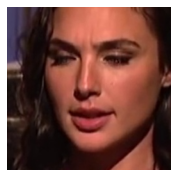

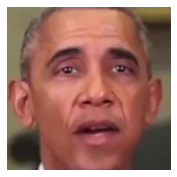

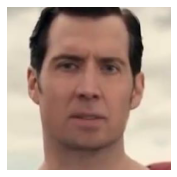

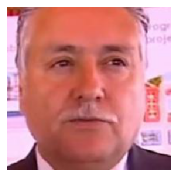

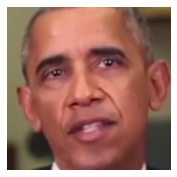

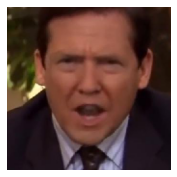

In [10]:
# 3 - Predict
for i in range(generator_test.n):
    X1, y1 = generator_test.next()
    #print(f"\nCorrect prediction: {round(1 - model.predict(X1)[0][0]) == y1[0]}")
    print('Predicted :', round(model.predict(X1)[0][0]), '\nReal class :', y1[0])
    plt.figure(figsize=(6, 3))
    plt.imshow(X1[0])
    plt.axis('off')